In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import re
import gspread
import json
import os
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

In [2]:
file_data = json.load(open(os.path.expanduser("../../../ServiceAccountsKey.json")))
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(
    ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)

ruland_gs = gc.open_by_url(
    "https://docs.google.com/spreadsheets/d/1od248fJpNbwMO8IVZQVO3xnzrmmTe68yS9XWajyuk5o/edit?usp=sharing")

In [3]:
lexeme_df = pd.read_parquet("../data/large_files/ruland-emlap-grela.parquet")

In [4]:
len(lexeme_df)

2846

In [39]:
lexeme_df.columns

Index(['Lemma', 'lemmas_all', 'target_canonical', 'entry_ids', 'entry_count',
       'types', 'variants', 'notes', 'senses_flat', 'sense_count',
       'sense_def_all', 'sense_def_strict_all', 'sense_raw_all',
       'translations_all', 'target_len', 'target_relemmatized',
       'instance_fname', 'noscemus_instances_N', 'cc_instances_N',
       'emlap_instances_N', 'emlap_instances', 'instances_ids',
       'instances_counter'],
      dtype='object')

In [5]:
lexeme_df.loc[1780]

Lemma                                                       Machina, Axia
lemmas_all                                                [Machina, Axia]
target_canonical                                            machina, axia
entry_ids                                      [Ruland1612-Machina,-Axia]
entry_count                                                             1
types                                                                 [M]
variants                                                               []
notes                                                                  []
senses_flat             [{'def': 'axis stratus', 'entry_id': 'Ruland16...
sense_count                                                             1
sense_def_all                                              [axis stratus]
sense_def_strict_all                                       [axis stratus]
sense_raw_all                                    [, axis stratus. Welle.]
translations_all        [{'entry_id': 

In [6]:
emlap_metadata = pd.read_csv(
        "https://raw.githubusercontent.com/CCS-ZCU/EMLAP_ETL/refs/heads/master/data/emlap_metadata.csv",
        sep=";",
    )
emlap_metadata.head(5)

Unnamed: 0.1  Unnamed: 0                 working_title  \
0             0           0        Augurello, Chrysopoeia   
1             1           1         Pseudo-Lull, Secretis   
2             2           2  Pantheus, Ars Transmutatione   
3             3           3          Anon, Vera alchemiae   
4             4           4        Pantheus, Voarchadumia   

                                           filenames     no.  is_done  \
0       100001_Augurello1515_Chrysopoeia_GB_Noscemus  100001     True   
1  100002_Pseudo-Lull1518_De secretis_naturae_MDZ...  100002     True   
2  100003_Pantheus1518_Ars_Transmutationis_Metall...  100003     True   
3            100004_Anon1561_Verae_Alchemiae_MDZ_MBS  100004     True   
4               100005_Pantheus1530_Voarchadumia_ONB  100005     True   

   is_noscemus  if_noscemus_id  AUTHORSHIP  is_one_author  ...  CONTENTS  \
0         True        713324.0         NaN           True  ...       NaN   
1        False             NaN         NaN           True  ...       NaN   
2        False             NaN         NaN           True  ...       NaN   
3        False             NaN         NaN           True  ...       NaN   
4        False             NaN         NaN           True  ...       NaN   

                     genre            subject SOURCE OF FILE  \
0            didactic poem            alchemy            NaN   
1                 treatise  alchemy, medicine            NaN   
2                 treatise            alchemy            NaN   
3  compendium, florilegium            alchemy            NaN   
4                 treatise            alchemy            NaN   

                                                link source_of_file  \
0       https://wiki.uibk.ac.at/noscemus/Chrysopoeia             GB   
1  https://www.digitale-sammlungen.de/en/view/bsb...            MDZ   
2  https://www.google.co.uk/books/edition/Ars_Tra...             GB   
3   https://mdz-nbn-resolving.de/details:bsb10141168            MDZ   
4                https://data.onb.ac.at/rep/10588E49            ONB   

  origin_of_copy  other_notes tokens_N  aurhor_wd  
0       Noscemus          NaN    23225        NaN  
1            MBS          NaN    24696        NaN  
2             BL          NaN     8683        NaN  
3            MBS          NaN   368660        NaN  
4            ONB          NaN    21175        NaN  

[5 rows x 57 columns]

In [7]:
emlap_metadata["tokens_N"].sum()

np.int64(6477016)

In [12]:
# to work excusively with works from the older period
#emlap_metadata = emlap_metadata[emlap_metadata["date_publication"]<=1600]

In [13]:
emlap_metadata.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'working_title', 'filenames', 'no.',
       'is_done', 'is_noscemus', 'if_noscemus_id', 'AUTHORSHIP',
       'is_one_author',
       '#if more than 1 author skip section and choose compendium below',
       'is_author_known', 'author_name', 'author_name_alternatives',
       'author_viaf', 'author_cerl', 'author_comments', 'is_compendium',
       'if_compendium', 'TRANSLATION / EDITORSHIP', 'is_translator',
       'translator_name', 'translator_name_alternatives',
       'translator_comments', 'is_editor', 'editor_name',
       'editor_name_alternatives', 'editor_comments', 'DATE OF PUBLICATION',
       'date_publication', 'date_certainty', 'date_not_after',
       'date_not_before', 'date_comment', 'TITLE', 'title_short', 'title_full',
       'title_viaf', 'title_comments', 'PLACE OF PUBLICATION',
       'place_publication', 'place_geonames', 'place_comments', 'PUBLISHER',
       'publisher_name', 'publisher_name_alternatives', 'publisher_comments'

In [14]:
emlap_metadata["labeldate"] = emlap_metadata.apply(lambda row: row["working_title"] + " ({})".format(str(row["date_publication"])), axis=1)

In [15]:
emlap_metadata.sort_values("date_publication", ascending=True, inplace=True)

## Exploring individual entries

In [16]:
# emlap_id_label_dict = dict(zip(emlap_metadata["No."], emlap_metadata["labeldate"]))

In [17]:
def extract_emlap_ids(emlap_instances):
    return [instance["grela_id"][6:] for instance in emlap_instances]

lexeme_df["instances_ids"] = lexeme_df["emlap_instances"].apply(extract_emlap_ids)

In [18]:
def make_plot_bar(entry):
    # Get instance IDs for the entry
    instances_ids = lexeme_df[lexeme_df["Lemma"] == entry]["instances_ids"].tolist()[0]
    counter = Counter(instances_ids)

    # Extract the keys (labels) and their corresponding counts (frequencies)
    emlap_metadata_instances = emlap_metadata.copy()
    emlap_metadata_instances["Frequency"] = (
        emlap_metadata_instances["no."].astype(str).map(counter).fillna(0).astype(int)
    )

    # Add bidecade labels to the DataFrame
    def get_bidecade_label(year):
        if not np.isnan(year):  # Handle NaN years safely
            start = (year // 20) * 20  # Determine the starting year of the bidecade
            end = start + 19  # Determine the ending year of the bidecade
            return f"{start}-{end}"
        return None

    emlap_metadata_instances["Bidecade"] = emlap_metadata_instances["date_publication"].apply(get_bidecade_label)

    # Group by Bidecade and sum frequencies and tokens_N
    emlap_instances_grouped = (
        emlap_metadata_instances.groupby("Bidecade", dropna=True)[["Frequency", "tokens_N"]]
        .sum()
        .reset_index()
    )

    # Sort bidecade intervals numerically
    emlap_instances_grouped = emlap_instances_grouped.sort_values(
        by="Bidecade",
        key=lambda col: col.str.extract(r"(\d+)")[0].astype(int)
    )

    # Calculate relative frequency (Frequency / tokens_N)
    emlap_instances_grouped["RelativeFrequency"] = (
        emlap_instances_grouped["Frequency"] / emlap_instances_grouped["tokens_N"]
    )

    # Calculate relative frequency for individual works
    emlap_metadata_instances["RelativeFrequency"] = (
        emlap_metadata_instances["Frequency"] / emlap_metadata_instances["tokens_N"]
    )

    # Create the 4 subplots (2x2 layout)
    fig, axes = plt.subplots(2, 2, figsize=(30, 12), dpi=300)

    # Plot 1: Absolute frequency vs. bidecades
    ax1 = axes[0, 0]
    ax1.bar(
        emlap_instances_grouped["Bidecade"],
        emlap_instances_grouped["Frequency"],
        color="blue"
    )
    ax1.set_xlabel("Bidecades", fontsize=12)
    ax1.set_ylabel("Absolute Frequency", fontsize=12)
    ax1.set_title(f"Absolute Frequency of '{entry}' by Bidecades", fontsize=14)
    ax1.set_xticks(range(len(emlap_instances_grouped["Bidecade"])))
    ax1.set_xticklabels(emlap_instances_grouped["Bidecade"], rotation=90)

    # Plot 2: Relative frequency vs. bidecades
    ax2 = axes[0, 1]
    ax2.bar(
        emlap_instances_grouped["Bidecade"],
        emlap_instances_grouped["RelativeFrequency"],
        color="orange"
    )
    ax2.set_xlabel("Bidecades", fontsize=12)
    ax2.set_ylabel("Relative Frequency (Frequency / tokens_N)", fontsize=12)
    ax2.set_title(f"Relative Frequency of '{entry}' by Bidecades", fontsize=14)
    ax2.set_xticks(range(len(emlap_instances_grouped["Bidecade"])))
    ax2.set_xticklabels(emlap_instances_grouped["Bidecade"], rotation=90)

    # Plot 3: Absolute frequency vs. works
    ax3 = axes[1, 0]
    ax3.bar(
        emlap_metadata_instances["labeldate"],
        emlap_metadata_instances["Frequency"],
        color="blue"
    )
    ax3.set_xlabel("Works", fontsize=12)
    ax3.set_ylabel("Absolute Frequency", fontsize=12)
    ax3.set_title(f"Absolute Frequency of '{entry}' by Works", fontsize=14)
    ax3.set_xticks(range(len(emlap_metadata_instances["labeldate"])))
    ax3.set_xticklabels(emlap_metadata_instances["labeldate"], rotation=90, fontsize=9)

    # Plot 4: Relative frequency vs. works
    ax4 = axes[1, 1]
    ax4.bar(
        emlap_metadata_instances["labeldate"],
        emlap_metadata_instances["RelativeFrequency"],
        color="orange"
    )
    ax4.set_xlabel("Works", fontsize=12)
    ax4.set_ylabel("Relative Frequency (Frequency / tokens_N)", fontsize=12)
    ax4.set_title(f"Relative Frequency of '{entry}' by Works", fontsize=14)
    ax4.set_xticks(range(len(emlap_metadata_instances["labeldate"])))
    ax4.set_xticklabels(emlap_metadata_instances["labeldate"], rotation=90, fontsize=9)

    # Adjust layout and display the plots
    plt.tight_layout()
    #plt.show()
    return fig

In [19]:
entry = "Lapis philosophorum"
instances_ids = lexeme_df[lexeme_df["Lemma"] == entry]["instances_ids"].tolist()[0]
counter = Counter(instances_ids)
emlap_metadata_instances = emlap_metadata.copy()
emlap_metadata_instances["Frequency"] = (
        emlap_metadata_instances["no."].astype(str).map(counter).fillna(0).astype(int))

In [20]:
emlap_metadata_instances.head(5)

Unnamed: 0.1  Unnamed: 0                    working_title  \
0              0           0           Augurello, Chrysopoeia   
1              1           1            Pseudo-Lull, Secretis   
2              2           2     Pantheus, Ars Transmutatione   
8              8           8  Vegius, Inter inferiora corpora   
12            12          12                  Ulstadt, Coelum   

                                            filenames     no.  is_done  \
0        100001_Augurello1515_Chrysopoeia_GB_Noscemus  100001     True   
1   100002_Pseudo-Lull1518_De secretis_naturae_MDZ...  100002     True   
2   100003_Pantheus1518_Ars_Transmutationis_Metall...  100003     True   
8   100009_Vegius1518_Inter_inferiora_corpora_disp...  100009     True   
12  100013_Ulstad1525_Coelum_philosophorum_Medica_...  100013     True   

    is_noscemus  if_noscemus_id  AUTHORSHIP  is_one_author  ...  \
0          True        713324.0         NaN           True  ...   
1         False             NaN         NaN           True  ...   
2         False             NaN         NaN           True  ...   
8         False             NaN         NaN          False  ...   
12        False             NaN         NaN           True  ...   

                   subject  SOURCE OF FILE  \
0                  alchemy             NaN   
1        alchemy, medicine             NaN   
2                  alchemy             NaN   
8   Renaissance philosophy             NaN   
12   alchemy, quintessence             NaN   

                                                 link source_of_file  \
0        https://wiki.uibk.ac.at/noscemus/Chrysopoeia             GB   
1   https://www.digitale-sammlungen.de/en/view/bsb...            MDZ   
2   https://www.google.co.uk/books/edition/Ars_Tra...             GB   
8                  http://data.onb.ac.at/rep/1099703B            ONB   
12  https://www.biusante.parisdescartes.fr/histmed...         Medica   

   origin_of_copy other_notes tokens_N  aurhor_wd  \
0        Noscemus         NaN    23225        NaN   
1             MBS         NaN    24696        NaN   
2              BL         NaN     8683        NaN   
8             ONB         NaN    27814        NaN   
12          BIUSP         NaN    41603  Q18026923   

                                 labeldate  Frequency  
0            Augurello, Chrysopoeia (1515)          0  
1             Pseudo-Lull, Secretis (1518)          4  
2      Pantheus, Ars Transmutatione (1518)          0  
8   Vegius, Inter inferiora corpora (1518)          0  
12                  Ulstadt, Coelum (1525)          7  

[5 rows x 59 columns]

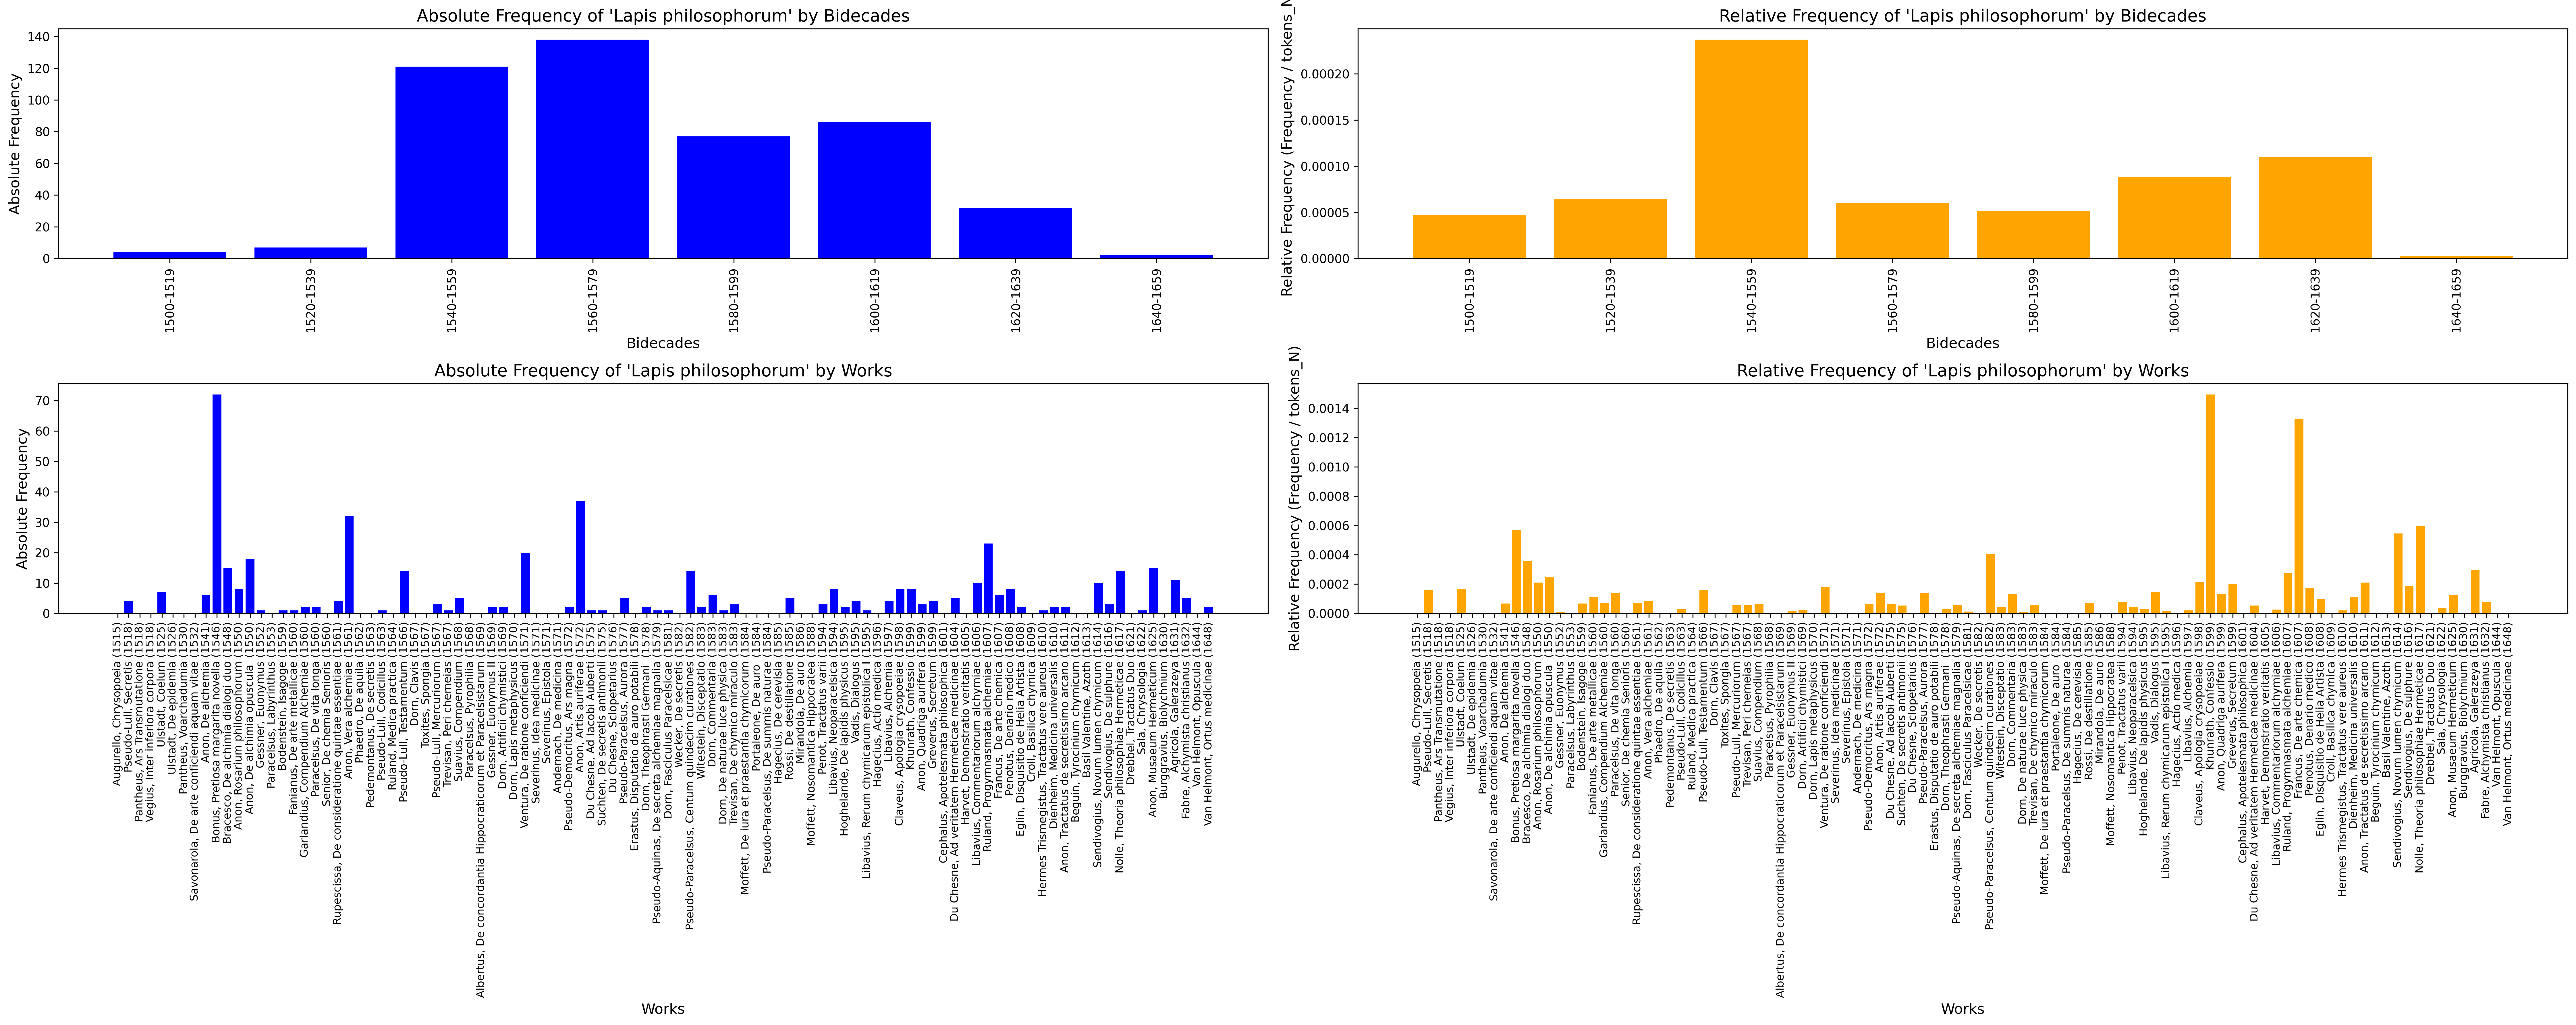

In [38]:
entry = "Lapis philosophorum"
fig = make_plot_bar(entry)

In [50]:
fig.savefig("../figures/casestudy_lapis_philosophorum.png", dpi=300)

## Overview

In [21]:
lexeme_df["emlap_instances_N"].sum()

np.int64(288785)

In [22]:
lexeme_df.sort_values("emlap_instances_N", ascending=False)[:10]

Lemma   lemmas_all target_canonical  \
596       Aurum      [Aurum]            aurum   
526    Argentum   [Argentum]         argentum   
29        Oleum      [Oleum]            oleum   
2277        Sal        [Sal]              sal   
96     Metallum   [Metallum]         metallum   
27    Mercurius  [Mercurius]        mercurius   
10      Sulphur    [Sulphur]          sulphur   
1200  Elementum  [Elementum]        elementum   
18     Essentia   [Essentia]         essentia   
197         Aer        [Aer]              aer   

                                              entry_ids  entry_count types  \
596                                  [Ruland1612-Aurum]            1   [A]   
526   [Ruland1612-Argentum-à-Chymistis-Luna,-cui-eti...            1   [A]   
29    [Ruland1612-Oleum, Ruland1612-Oleum, Ruland161...            3   [O]   
2277                                   [Ruland1612-Sal]            1   [S]   
96           [Ruland1612-Metallum, Ruland1612-Metallum]            2   [M]   
27    [Ruland1612-Mercurius, Ruland1612-Mercurius, R...            3   [M]   
10    [Ruland1612-Sulphur, Ruland1612-Sulphur, Rulan...            4   [S]   
1200                             [Ruland1612-Elementum]            1   [E]   
18    [Ruland1612-Essentia, Ruland1612-Essentia, Rul...            3   [E]   
197                                    [Ruland1612-Aer]            1   [A]   

        variants                                              notes  \
596           []  [Natiuum purum, quod a natura tale est, cuius ...   
526   [Argentum]                                                 []   
29            []                                                 []   
2277          []                                                 []   
96            []                                                 []   
27            []                                                 []   
10            []                                                 []   
1200          []                                                 []   
18            []                                                 []   
197           []                                                 []   

                                            senses_flat  sense_count  ...  \
596   [{'def': 'à Germanis', 'entry_id': 'Ruland1612...            1  ...   
526   [{'def': 'à Chymistis Luna, cui etiam tribuitu...            1  ...   
29    [{'def': 'id est, ignis, wirdt außgezogen von ...            3  ...   
2277  [{'def': 'Alas Graece, Melech Arabice, vel sel...            1  ...   
96    [{'def': 'vena, Ertz.', 'entry_id': 'Ruland161...            2  ...   
27    [{'def': 'id est, sulphur.', 'entry_id': 'Rula...            3  ...   
10    [{'def': 'chibur, vel, Albusao Arabice dicitur...            4  ...   
1200  [{'def': 'quicquid ex matricibus elementorum p...            1  ...   
18    [{'def': 'est extractum simplex e reb. tota su...            3  ...   
197   [{'def': 'id est, aura, halitus, spiritus, ven...            1  ...   

                                          sense_raw_all  \
596   [, à Germanis Goldtsa Chymistis dicitur Sol, &...   
526   [à Chymistis Luna, cui etiam tribuitur: estque...   
29    [id est, ignis, wirdt außgezogen von einer tro...   
2277  [Alas Graece, Melech Arabice, vel selenipum es...   
96           [vena, Ertz., id est, conflatum argentum.]   
27    [id est, sulphur. Mercurius. Mercurius ist in ...   
10    [chibur, vel, Albusao Arabice dicitur, pars la...   
1200  [quicquid ex matricibus elementorum prouenit, ...   
18    [est extractum simplex e reb. tota sua natura ...   
197   [id est, aura, halitus, spiritus, ventus, Wett...   

                                       translations_all target_len  \
596   [{'entry_id': 'Ruland1612-Aurum', 'quote': 'Go...          1   
526   [{'entry_id': 'Ruland1612-Argentum-à-Chymistis...          1   
29    [{'entry_id': 'Ruland1612-Oleum', 'quote': 'wi...          1   
2277  [{'entry_id': 'Ruland1612-Sal', 'quote': 'Sal

In [23]:
set_with_dataframe(ruland_gs.add_worksheet("ruland_top10_2025-12-16", 1,1), lexeme_df[['Lemma', 'target_canonical', 'target_relemmatized', 'emlap_instances_N']].sort_values("emlap_instances_N", ascending=False)[:10])

APIError: APIError: [400]: Invalid requests[0].addSheet: A sheet with the name "ruland_top10_2025-12-16" already exists. Please enter another name.

In [54]:
lexeme_df[['Lemma', 'target_canonical', 'target_relemmatized', 'emlap_instances_N']].sort_values("emlap_instances_N", ascending=False).to_csv("../data/lexeme_df_instances.csv")

In [55]:
lexeme_df[lexeme_df["target_len"]>1].sort_values("emlap_instances_N", ascending=False)[:10]

Lemma             lemmas_all     target_canonical  \
33        Quinta essentia      [Quinta essentia]      quinta essentia   
494            Aqua vitae           [Aqua vitae]           aqua uitae   
478           Aqua fortis          [Aqua fortis]          aqua fortis   
2285       Sal armoniacus       [Sal armoniacus]       sal armoniacus   
1698  Lapis philosophorum  [Lapis philosophorum]  lapis philosophorum   
602        Aurum potabile       [Aurum potabile]       aurum potabile   
46         Balneum Mariae       [Balneum Mariae]       balneum mariae   
1845        Materia prima        [Materia prima]        materia prima   
789       Calor naturalis      [Calor naturalis]      calor naturalis   
2307           Sal petrae           [Sal petrae]           sal petrae   

                                              entry_ids  entry_count types  \
33    [Ruland1612-Quinta-essentia, Ruland1612-Quinta...            3   [Q]   
494                             [Ruland1612-Aqua-vitae]            1   [A]   
478                            [Ruland1612-Aqua-fortis]            1   [A]   
2285                        [Ruland1612-Sal-armoniacus]            1   [S]   
1698                   [Ruland1612-Lapis-philosophorum]            1   [L]   
602                         [Ruland1612-Aurum-potabile]            1   [A]   
46    [Ruland1612-Balneum-Mariae, Ruland1612-Balneum...            2   [B]   
1845                         [Ruland1612-Materia-prima]            1   [M]   
789                        [Ruland1612-Calor-naturalis]            1   [C]   
2307                            [Ruland1612-Sal-petrae]            1   [S]   

     variants notes                                        senses_flat  \
33         []    []  [{'def': 'est natura vires, virtus color vita,...   
494        []    []  [{'def': 'id est, Mercurius', 'entry_id': 'Rul...   
478        []    []  [{'def': 'est, quae ex auibus, & corrosiuis ce...   
2285       []    []  [{'def': 'id est, sal saparicius, vel defossum...   
1698       []    []  [{'def': 'sein die Haar der Menschen.', 'entry...   
602        []    []  [{'def': 'est liquor, sine corrosiuo, quod pau...   
46         []    []  [{'def': 'id est, aqua calida.', 'entry_id': '...   
1845       []    []  [{'def': '& huius vocabula,', 'entry_id': 'Rul...   
789        []    []  [{'def': 'est, quando radii solares, vel per s...   
2307       []    []  [{'def': 'est, quod in testudinibus cellarum n...   

      sense_count  ...                                      sense_raw_all  \
33              3  ...  [est natura vires, virtus color vita, spiritus...   
494             1  ...  [, id est, Mercurius; interdum pro vino destil...   
478             1  ...  [est, quae ex auibus, & corrosiuis certa propo...   
2285            1  ...  [id est, sal saparicius, vel defossum, vel sal...   
1698            1  ...                      [sein die Haar der Menschen.]   
602             1  ...  [est liquor, sine corrosiuo, quod paucissimi n...   
46              2  ...  [id est, aqua calida., , vel maris, vt multi v...   
1845            1  ...  [& huius vocabula, die philosophi haben sich o...   
789             1  ...  [est, quando radii solares, vel per se materia...   
2307            1  ...  [est, quod in testudinibus cellarum nascitur i...   

                                       translations_all target_len  \
33    [{'entry_id': 'Ruland1612-Quinta-essentia', 'q...          2   
494   [{'entry_id': 'Ruland1612-Aqua-vitae', 'quote'...          2   
478                                                  []          2   
2285  [{'entry_id': 'Ruland1612-Sal-armoniacus', 'qu...          2   
1698  [{'entry_id': 'Ruland1612-Lapis-philosophorum'...          2   
602                                                  []          2   
46                                                   []          2   
1845  [{'entry_id': 'Ruland1612-Materia-prima', 'quo...          2   
789                                                  []         

## Distributions of EMLAP works

In [25]:
lexeme_df["instances_counter"] = lexeme_df["instances_ids"].apply(Counter)

In [26]:
lexeme_df["instances_counter"].tolist()[:10]

[Counter({'100085': 14, '100012': 3, '100038': 1, '100063': 1, '100070': 1}),
 Counter({'100004': 2}),
 Counter({'100070': 102,
          '100034': 99,
          '100004': 46,
          '100072': 41,
          '100015': 39,
          '100075': 36,
          '100085': 36,
          '100044': 35,
          '100067': 34,
          '100076': 21,
          '100091': 18,
          '100032': 15,
          '100084': 14,
          '100038': 12,
          '100093': 12,
          '100012': 10,
          '100030': 9,
          '100069': 9,
          '100087': 9,
          '100081': 8,
          '100100': 8,
          '100005': 7,
          '100039': 7,
          '100043': 7,
          '100046': 7,
          '100011': 6,
          '100026': 6,
          '100049': 6,
          '100028': 5,
          '100097': 5,
          '100010': 4,
          '100013': 4,
          '100020': 4,
          '100016': 3,
          '100027': 3,
          '100073': 3,
          '100079': 3,
          '100098': 3,
      

In [27]:
distribution = sum(lexeme_df["instances_counter"], Counter())

In [28]:
distribution

Counter({'100004': 21381,
         '100085': 19893,
         '100070': 18155,
         '100072': 15367,
         '100100': 13915,
         '100038': 13671,
         '100067': 9225,
         '100032': 7573,
         '100015': 6759,
         '100075': 6751,
         '100016': 6731,
         '100097': 5953,
         '100065': 5278,
         '100012': 5242,
         '100011': 5187,
         '100028': 5075,
         '100084': 4514,
         '100022': 4447,
         '100074': 4443,
         '100044': 4186,
         '100094': 4075,
         '100071': 3783,
         '100069': 3330,
         '100091': 3163,
         '100059': 3129,
         '100010': 3123,
         '100076': 3061,
         '100049': 2924,
         '100030': 2680,
         '100063': 2569,
         '100013': 2451,
         '100040': 2402,
         '100045': 2402,
         '100007': 2290,
         '100087': 2241,
         '100034': 2240,
         '100064': 2238,
         '100046': 2211,
         '100020': 2130,
         '100056': 

In [29]:
df = emlap_metadata.copy()
df["Frequency"] = (
        df["no."].astype(str).map(distribution).fillna(0).astype(int)
    )
df["RelativeFrequency"] = df["Frequency"] / df["tokens_N"]

    # Sort by publication date for a chronological x-axis
# df = df.sort_values(["date_publication", "labeldate"], na_position="last")



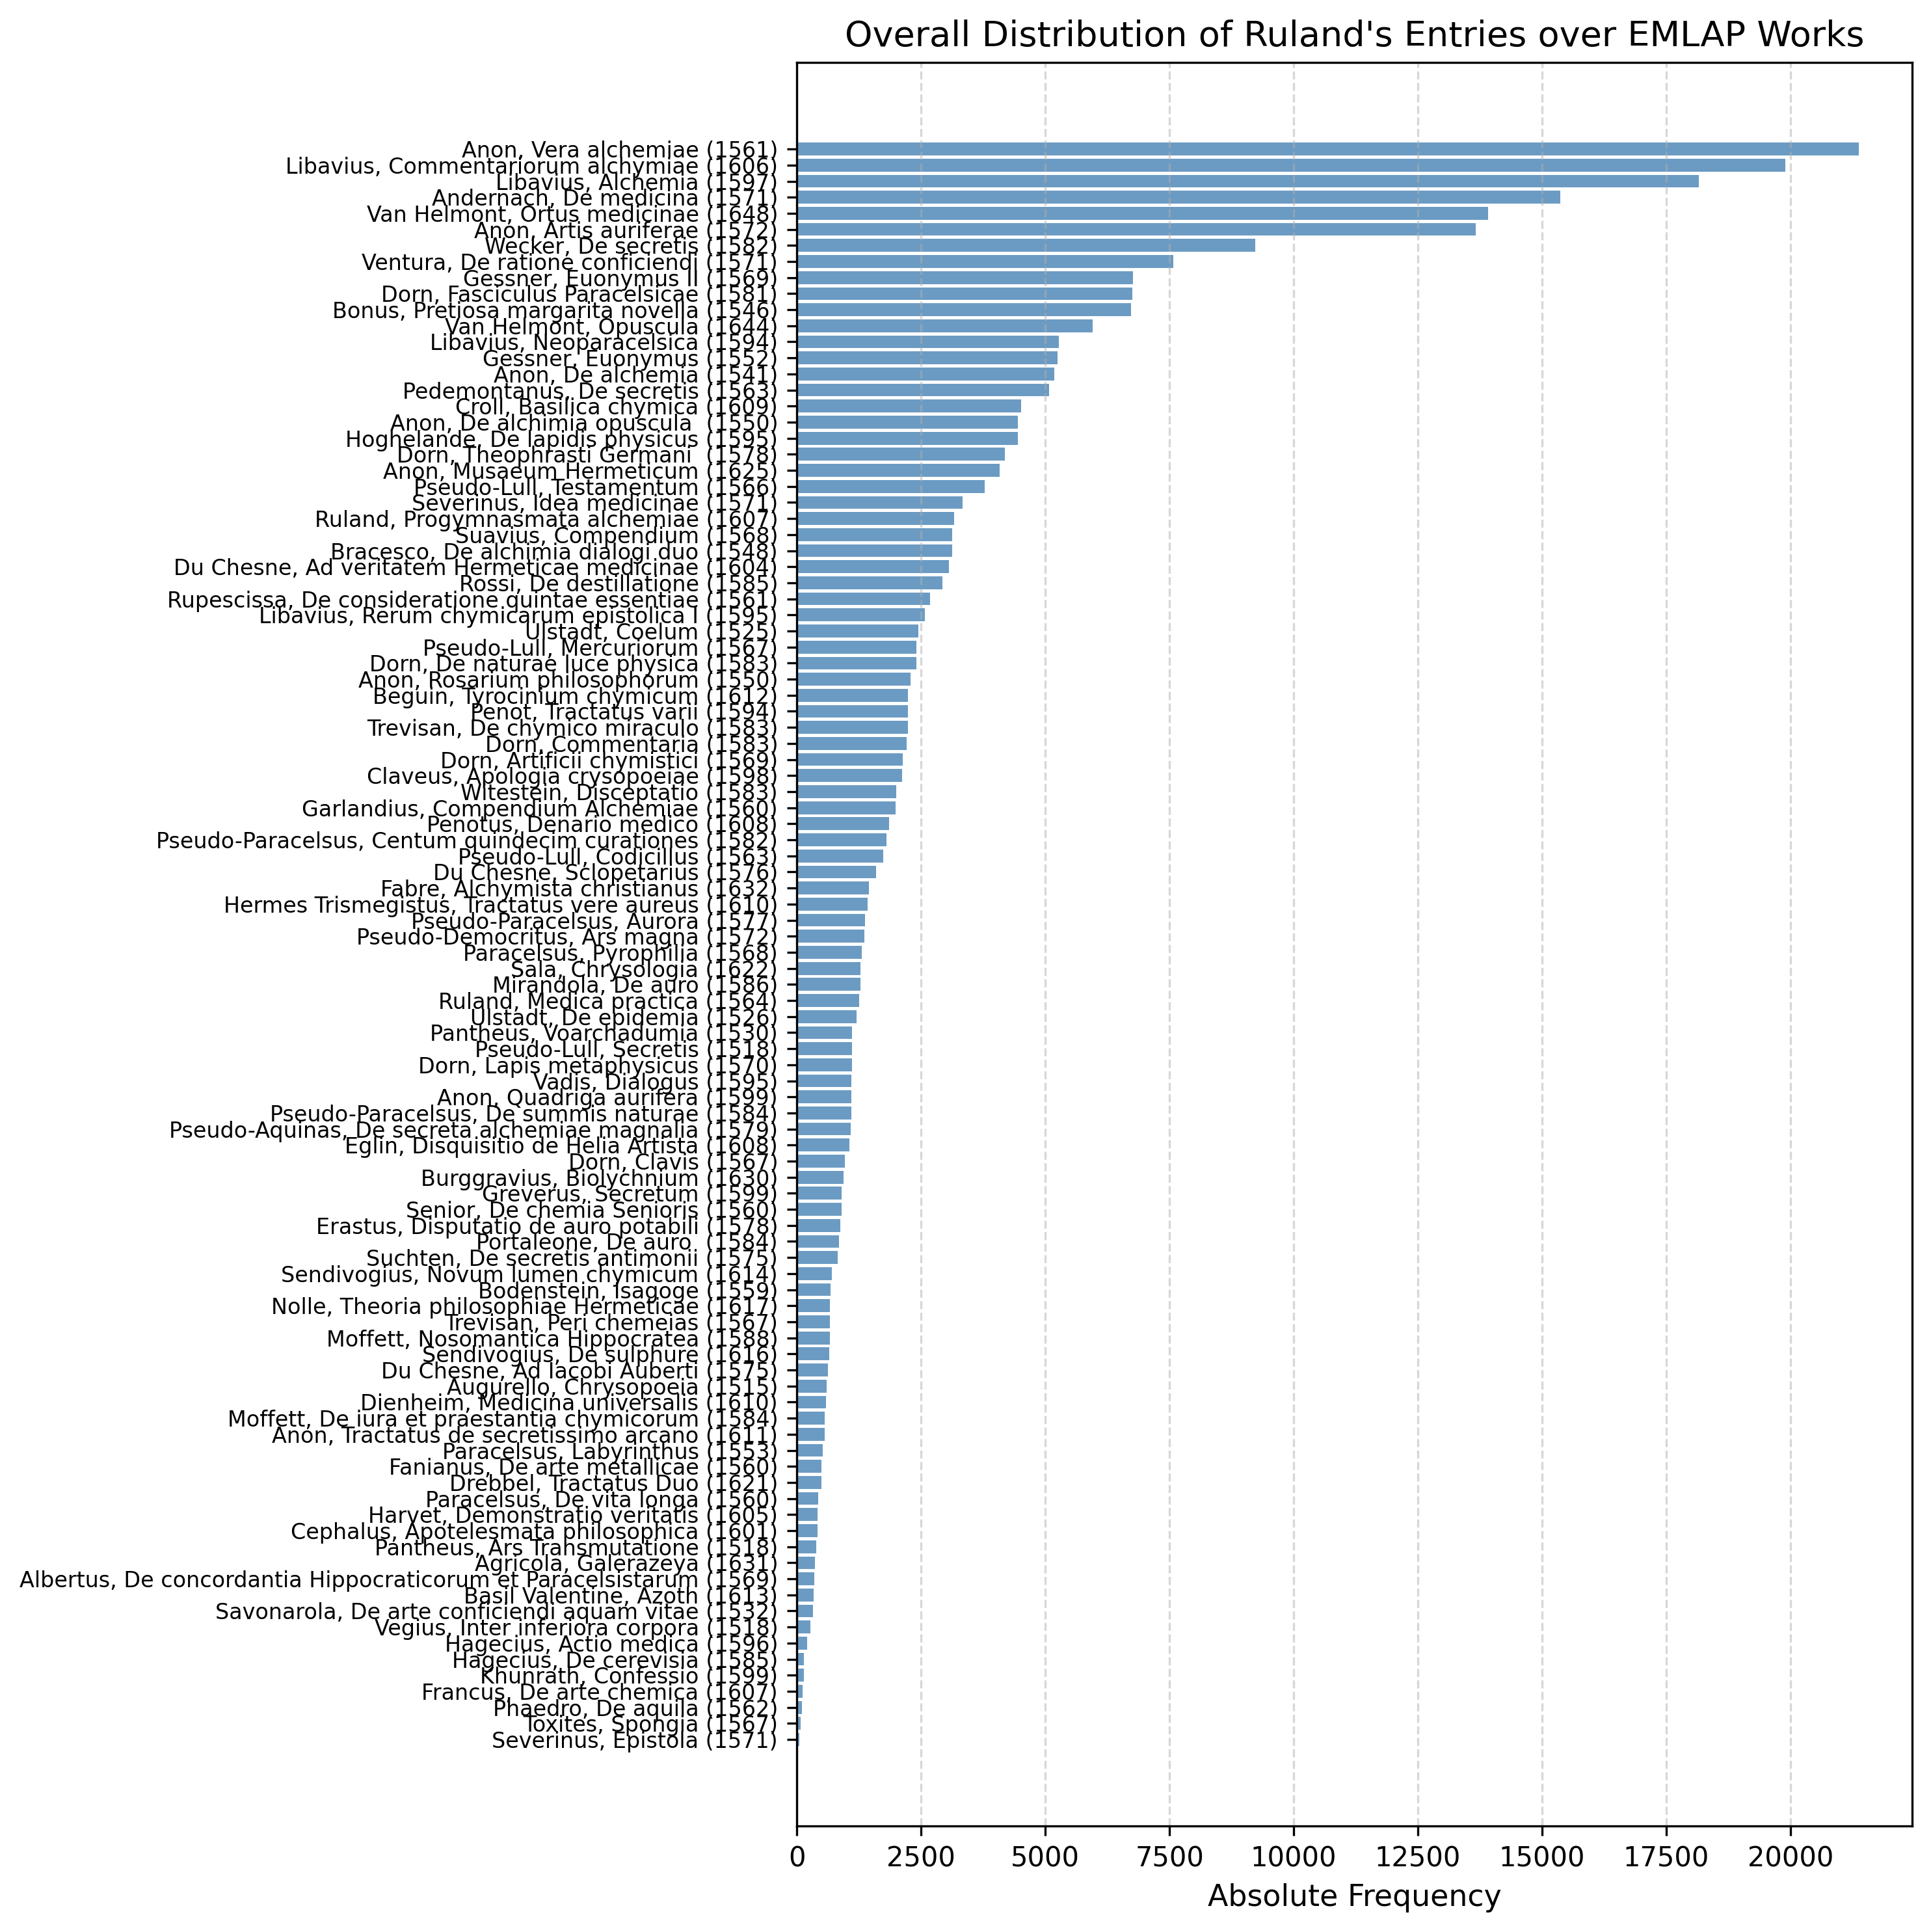

In [30]:
# Sort descending by Frequency
df = df.sort_values("Frequency", ascending=False)

# Prepare labels and positions
x_labels = df["labeldate"].tolist()
y_pos = np.arange(len(x_labels))

# Title
title = "Overall Distribution of Ruland's Entries over EMLAP Works"

# Create the figure
fig, ax = plt.subplots(figsize=(10, 10), dpi=300, tight_layout=True)

# Horizontal bar plot (sorted)
ax.barh(y_pos, df["Frequency"].to_numpy(), color="steelblue", alpha=0.8)

# Labeling
ax.set_yticks(y_pos)
ax.set_yticklabels(x_labels, fontsize=8)
ax.invert_yaxis()  # Highest at the top
ax.set_xlabel("Absolute Frequency", fontsize=11)
ax.set_title(title, fontsize=13)

# Add gridlines for readability
ax.grid(axis="x", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

In [31]:
fig.savefig("../figures/ruland-emlap-overall-distribution-absolute.png", dpi=300)

In [32]:
df[-5:]["tokens_N"]

51    5358
98    4512
30    2489
13    2646
7     2261
Name: tokens_N, dtype: int64

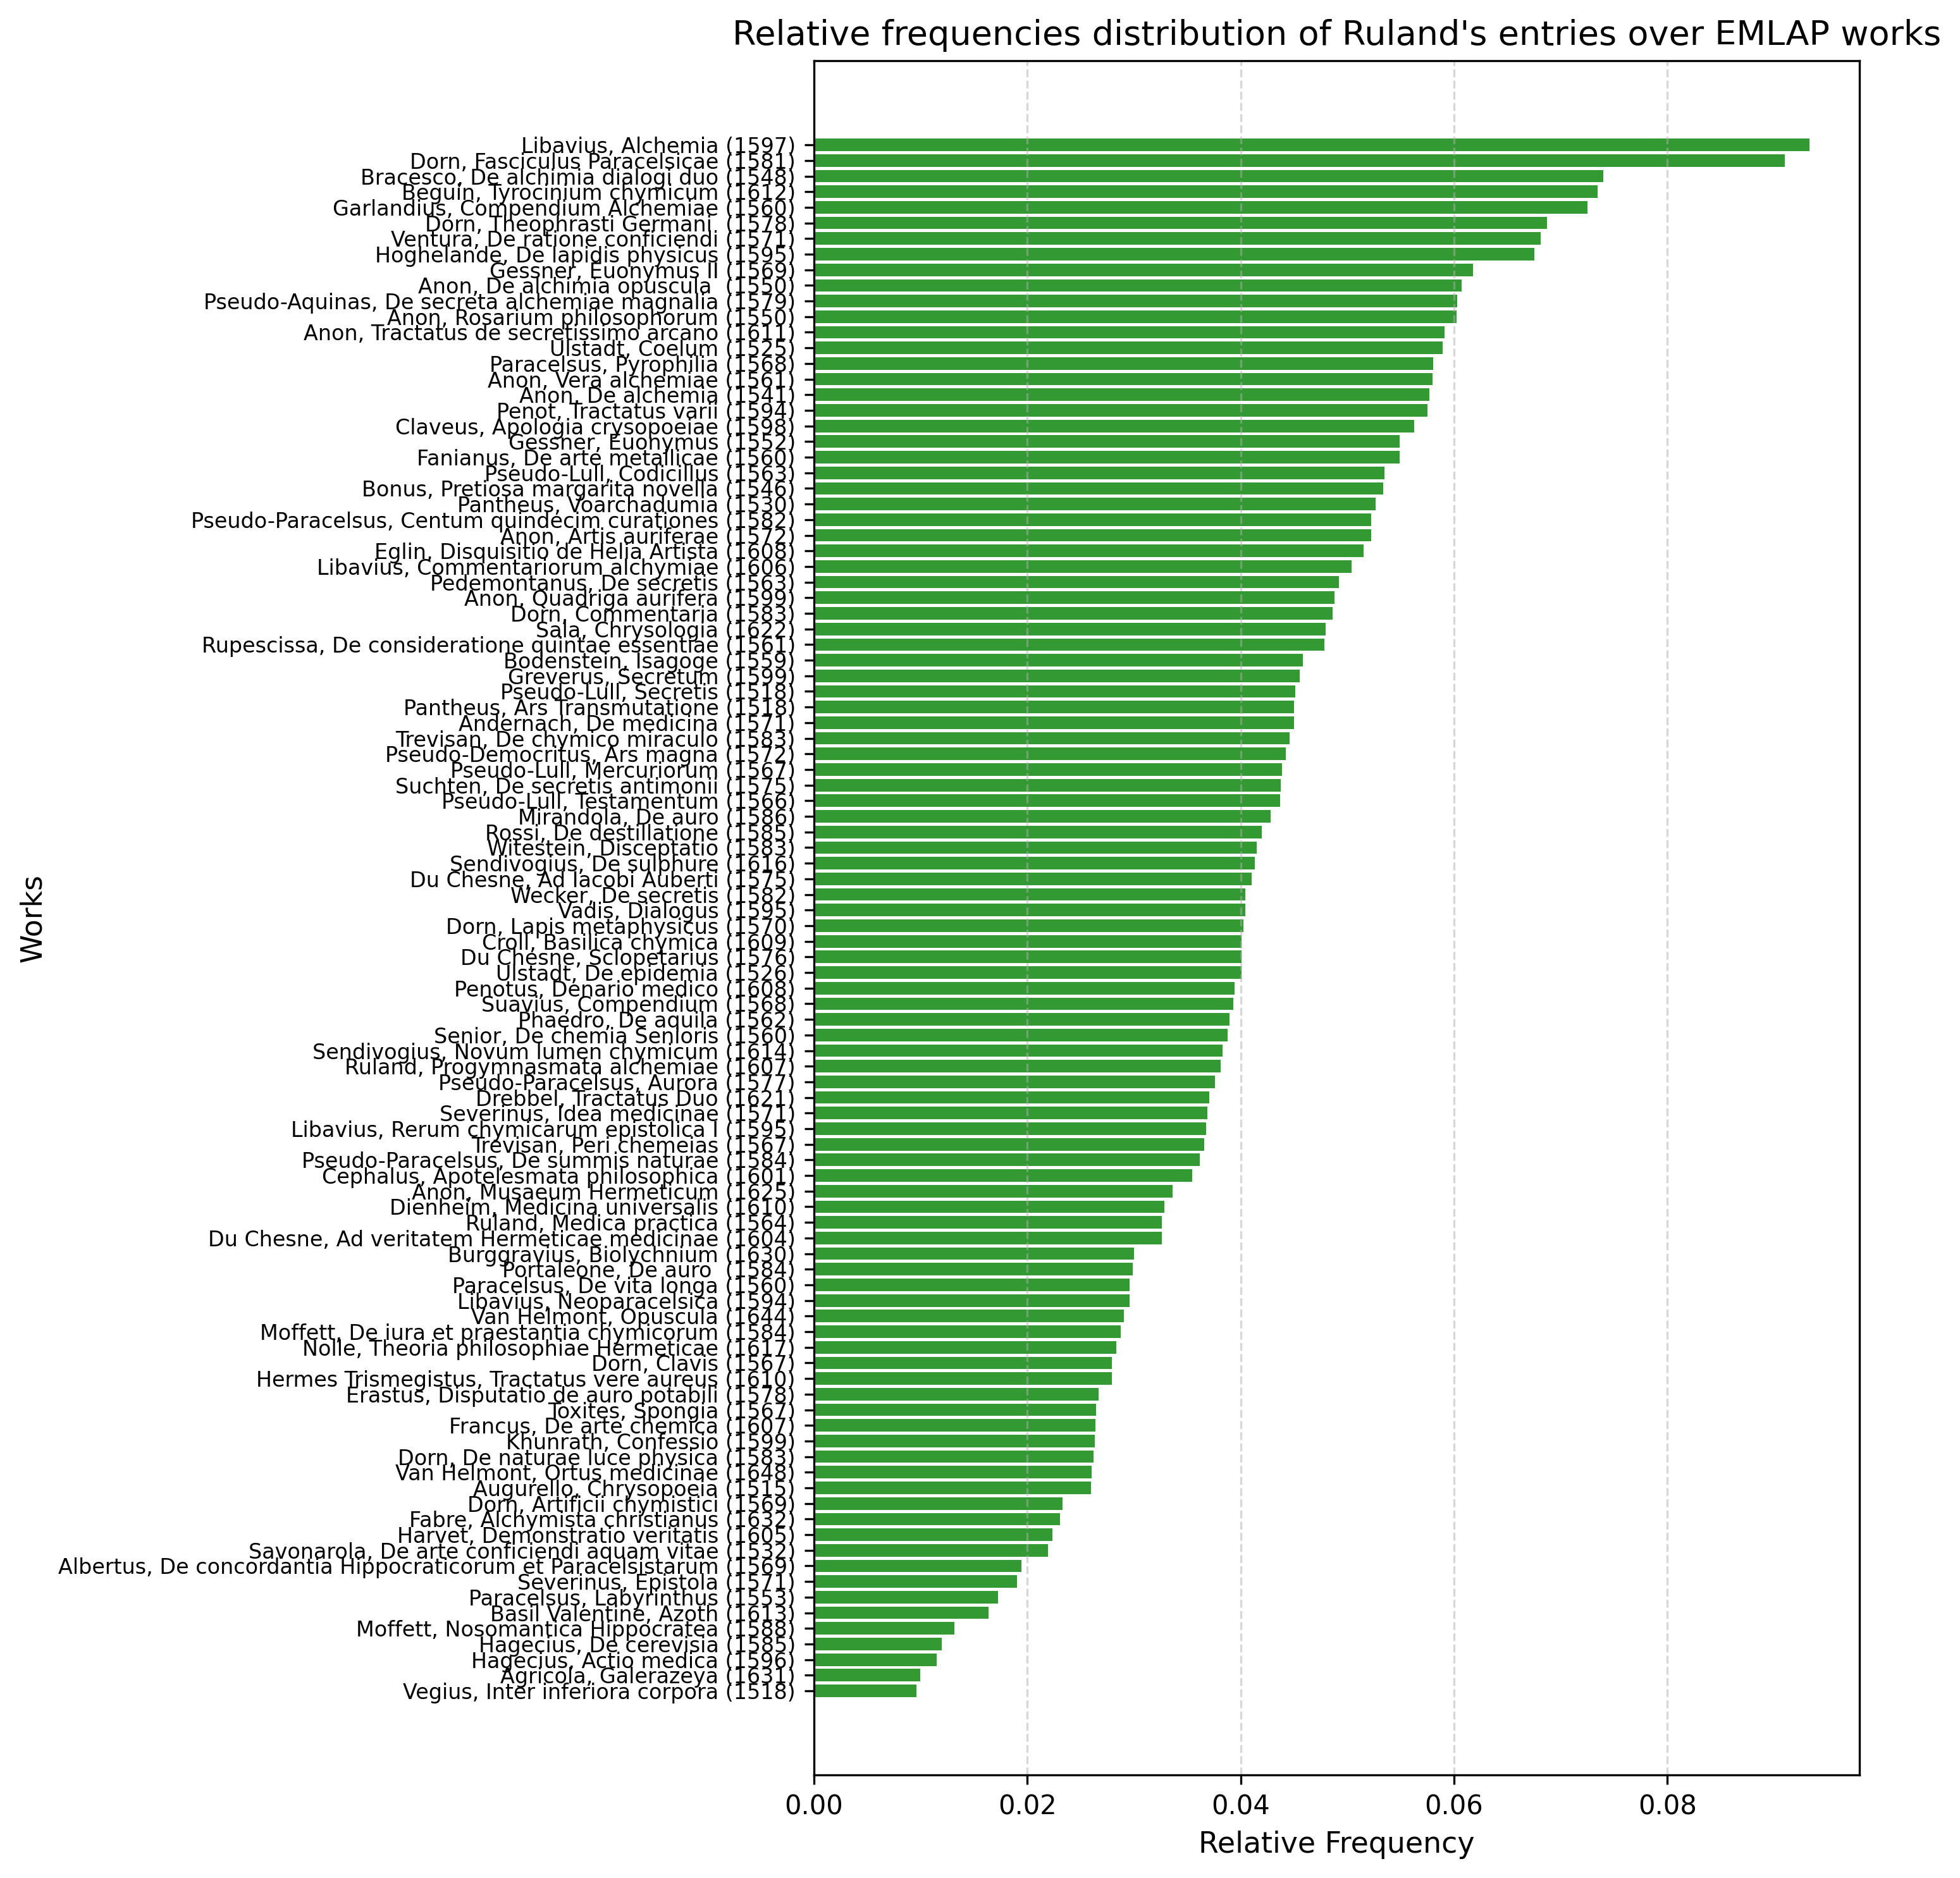

In [33]:
title = "Relative frequencies distribution of Ruland's entries over EMLAP works"
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=300, tight_layout=True)

df = df.sort_values("RelativeFrequency", ascending=False)

x_labels = df["labeldate"].tolist()
y_pos


# Horizontal bar plot (sorted)
ax.barh(y_pos, df["RelativeFrequency"].to_numpy(), color="green", alpha=0.8)

# Labeling
ax.set_yticks(y_pos)
ax.set_ylabel("Works", fontsize=11)
ax.set_yticklabels(x_labels, fontsize=8)
ax.invert_yaxis()  # Highest at the top
ax.set_xlabel("Relative Frequency", fontsize=11)
ax.set_title(title, fontsize=13)

# Add gridlines for readability
ax.grid(axis="x", linestyle="--", alpha=0.5)


plt.tight_layout()
plt.show()

In [34]:
fig.savefig("../figures/ruland-emlap-overall-distribution-relative.png", dpi=300)

In [35]:
emlap_metadata["no."] = emlap_metadata["no."].astype(str)

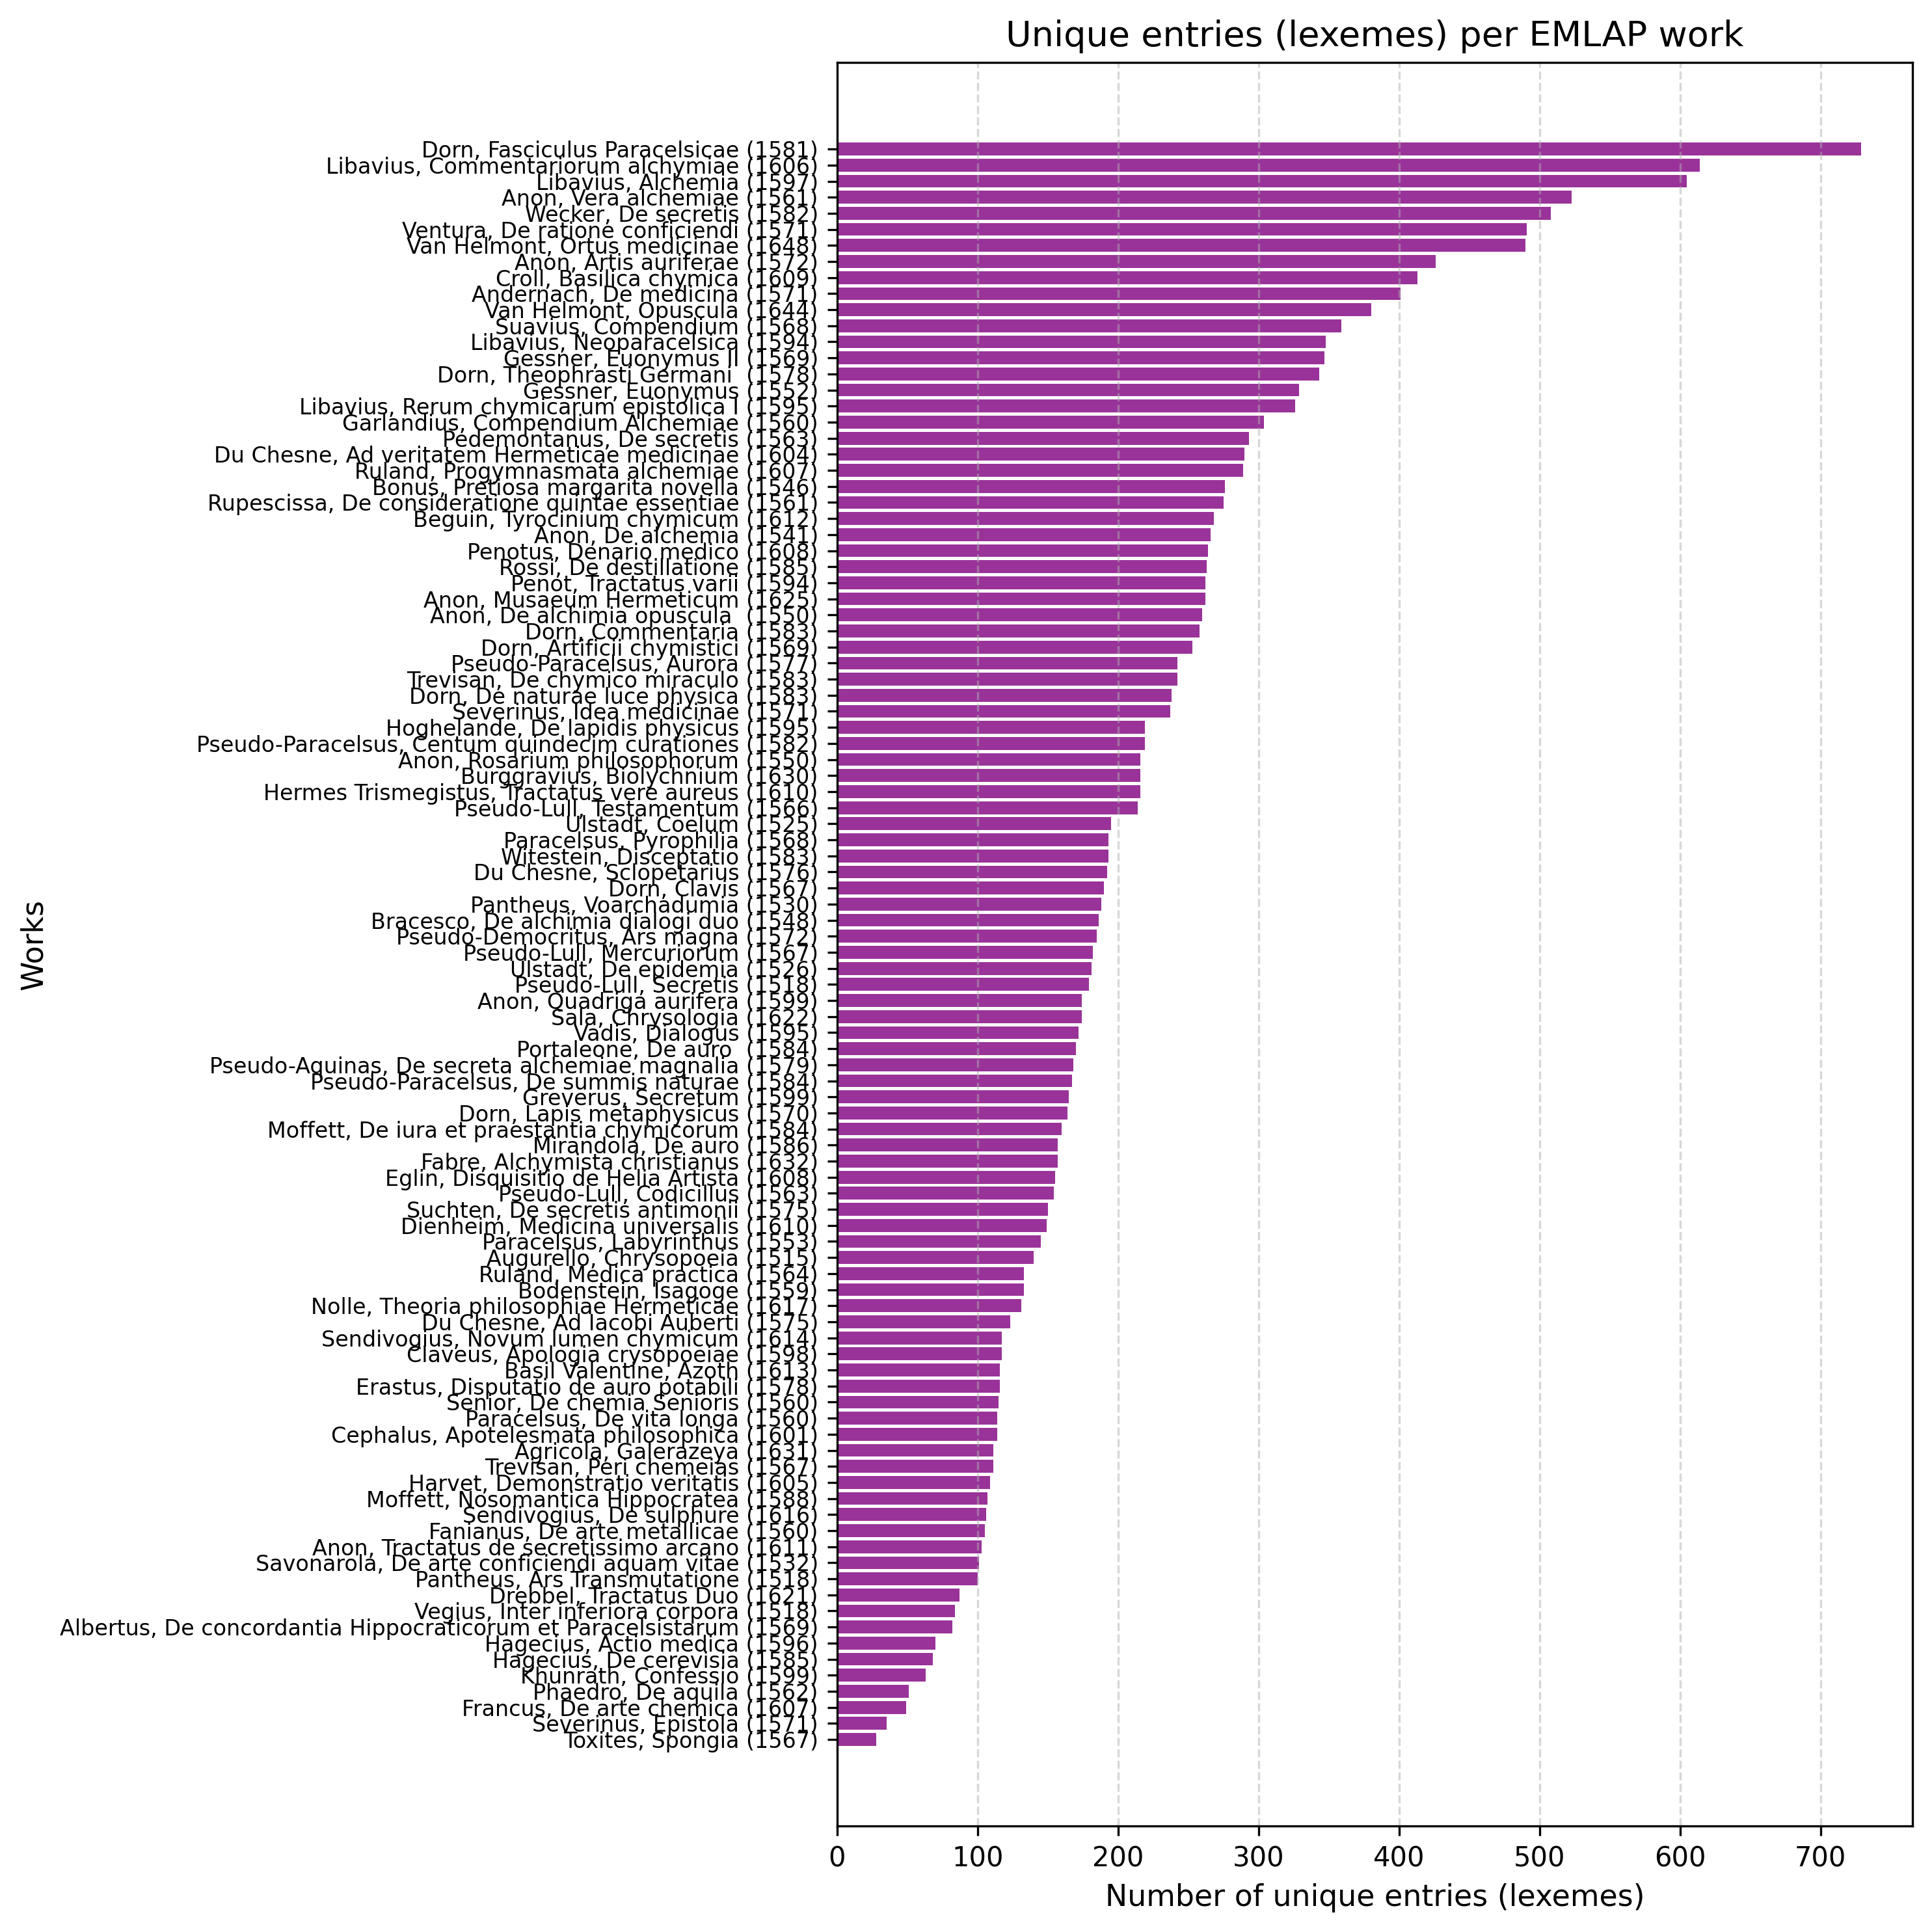

In [37]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) work_id → set of lexemes
work_to_lexemes = defaultdict(set)

# 2) Fill mapping from lexeme_df
for _, row in lexeme_df.iterrows():
    lemma = row["Lemma"]
    for work_id in row["instances_ids"]:
        work_to_lexemes[str(work_id)].add(lemma)

# 3) Counts DF
work_entry_counts = pd.DataFrame(
    [{"no.": w, "unique_entries": len(lemmas)} for w, lemmas in work_to_lexemes.items()]
)

# 4) Merge with metadata
work_entry_counts = emlap_metadata.merge(work_entry_counts, on="no.", how="left")
work_entry_counts["unique_entries"] = work_entry_counts["unique_entries"].fillna(0).astype(int)

# 5) Sort like your barh example (by value descending)
work_entry_counts = work_entry_counts.sort_values("unique_entries", ascending=False)

# 6) Plot barh
title = "Unique entries (lexemes) per EMLAP work"
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=300, tight_layout=True)

y_pos = np.arange(len(work_entry_counts))
x_labels = work_entry_counts["labeldate"].tolist()

ax.barh(y_pos, work_entry_counts["unique_entries"].to_numpy(), color="purple", alpha=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels(x_labels, fontsize=8)
ax.invert_yaxis()  # biggest on top

ax.set_xlabel("Number of unique entries (lexemes)", fontsize=11)
ax.set_ylabel("Works", fontsize=11)
ax.set_title(title, fontsize=13)

ax.grid(axis="x", linestyle="--", alpha=0.5)

plt.show()

In [38]:
fig.savefig("../figures/ruland-emlap-unique-entries.png", dpi=300)